# Clustering audio à partir des fichiers chroma

On commence ici par étudier le datatset Cross-composer composé d'oeuvres de 11 compositeurs, l'objectif étant d'élargir avec le dataset Cross-era qui pourrait permettre de faire du clustering sur des périodes musicales.

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Récupération d'un fichier

In [2]:
filename = "cross-composer\chroma-nnls_01_bach.csv"

<>:1: SyntaxWarning: invalid escape sequence '\c'
<>:1: SyntaxWarning: invalid escape sequence '\c'
C:\Users\PCAJM\AppData\Local\Temp\ipykernel_17256\4245396539.py:1: SyntaxWarning: invalid escape sequence '\c'
  filename = "cross-composer\chroma-nnls_01_bach.csv"


### Récupération de chaque fichier en dataframe

In [3]:
dataframe = pd.read_csv(filename)

In [19]:
def to_dataframes(filename):
    """
    Reads a CSV file and returns a dictionary of DataFrame.
    """
    li_notes = ['time','A','A#','B','C','C#','D','D#','E','F','F#','G','G#']
    df = pd.read_csv(filename)
    title = None
    dataf = []
    dataframes = {}
    for i, row in df.iterrows():
        if pd.notna(row[0]):
            if title is not None:
                dataframes[title] = pd.DataFrame(dataf, columns=li_notes)
                dataframes[title].set_index('time', inplace=True)
            title = row[0]
            dataf = []
        else:
            dataf.append(row[1:].tolist())
    
    if title is not None:
        dataframes[title] = pd.DataFrame(dataf, columns=li_notes)
        dataframes[title].set_index('time', inplace=True)
    return dataframes

In [20]:
dataf = to_dataframes(filename)

C:\Users\PCAJM\AppData\Local\Temp\ipykernel_17256\2848940793.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if pd.notna(row[0]):
C:\Users\PCAJM\AppData\Local\Temp\ipykernel_17256\2848940793.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  title = row[0]


In [22]:
dataf.keys()

dict_keys(['01_bach/CrossComp-0056_01_bach_11_bwv_880_in_fmaj.mp3', '01_bach/CrossComp-0057_01_bach_12_bwv_881_in_fmin.mp3', '01_bach/CrossComp-0058_01_bach_13_bwv_882_in_fmaj.mp3', '01_bach/CrossComp-0059_01_bach_14_bwv_883_in_fmin.mp3', '01_bach/CrossComp-0060_01_bach_15_bwv_884_in_gmaj.mp3', '01_bach/CrossComp-0061_01_bach_16_bwv_885_in_gmin.mp3', '01_bach/CrossComp-0062_01_bach_17_bwv_886_in_abmaj.mp3', '01_bach/CrossComp-0063_01_bach_18_bwv_887_in_abmin.mp3', '01_bach/CrossComp-0064_01_bach_19_bwv_888_in_amaj.mp3', '01_bach/CrossComp-0046_01_bach_1_bwv_870_in_cmaj.mp3', '01_bach/CrossComp-0065_01_bach_20_bwv_889_in_amin.mp3', '01_bach/CrossComp-0066_01_bach_21_bwv_890_in_bbmaj.mp3', '01_bach/CrossComp-0067_01_bach_22_bwv_891_in_bbmin.mp3', '01_bach/CrossComp-0068_01_bach_23_bwv_892_in_bmaj.mp3', '01_bach/CrossComp-0069_01_bach_24_bwv_893_in_bmin.mp3', '01_bach/CrossComp-0047_01_bach_2_bwv_871_in_cmin.mp3', '01_bach/CrossComp-0048_01_bach_3_bwv_872_in_cmaj.mp3', '01_bach/CrossComp-

In [21]:
dataf['01_bach/CrossComp-0056_01_bach_11_bwv_880_in_fmaj.mp3']

,A,A#,B,C,C#,D,D#,E,F,F#,G,G#
time,,,,,,,,,,,,
0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
283.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
283.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
283.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
data = dataf['01_bach/CrossComp-0057_01_bach_12_bwv_881_in_fmin.mp3']

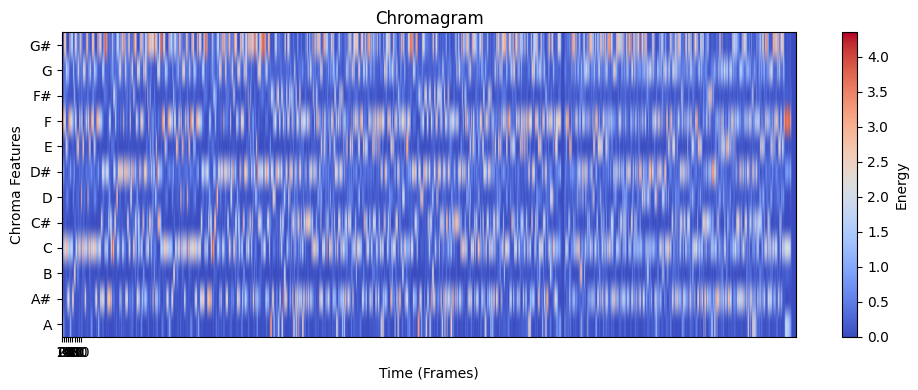

In [29]:
plt.figure(figsize=(10, 4))
plt.imshow(data.T, aspect='auto', origin='lower', cmap='coolwarm')
plt.colorbar(label='Energy')
plt.title('Chromagram')
plt.xlabel('Time (Frames)')
plt.ylabel('Chroma Features')
plt.xticks(ticks=np.arange(0, 100, 10), labels=np.arange(0, 100, 10))  # Ajustez les ticks si nécessaire
plt.yticks(ticks=np.arange(12), labels=data.columns)  # Noms des chroma
plt.tight_layout()
plt.show()